# Random vs Temporal Splits: Model Performance Comparison

This notebook compares the performance of Logistic Regression and k-Nearest Neighbors (kNN) models when trained on:
1. **Random Split**: Data randomly shuffled and split (70% train, 15% val, 15% test)
2. **Temporal Split**: Data split sequentially by time (60% train, 20% val, 20% test)

**Key Question**: How does data leakage from temporal correlation affect model performance?

**Context**: This dataset consists of consecutive frames from a car driving on a track. Consecutive frames are highly similar, which means:
- Random splits may leak information (test frames similar to training frames)
- Temporal splits provide a more realistic evaluation (test on future frames)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    balanced_accuracy_score, f1_score, precision_score, recall_score
)
import warnings
warnings.filterwarnings('ignore')

# Import shared utilities
from utils import (
    CLASSES, RANDOM_STATE, CLASS_COLORS, evaluate_model
)
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load Pre-split Data

Load the random and temporal splits that were created in the EDA notebook.

In [18]:
# Paths
DATA_DIR = Path('../../data')

# Load random splits
print("Loading random splits...")
random_data = np.load(DATA_DIR / 'splits_random.npz', allow_pickle=True)
X_train_rand = random_data['X_train']
y_train_rand = random_data['y_train']
X_val_rand = random_data['X_val']
y_val_rand = random_data['y_val']
X_test_rand = random_data['X_test']
y_test_rand = random_data['y_test']

# Load temporal splits
print("Loading temporal splits...")
temporal_data = np.load(DATA_DIR / 'splits_temporal.npz', allow_pickle=True)
X_train_temp = temporal_data['X_train']
y_train_temp = temporal_data['y_train']
X_val_temp = temporal_data['X_val']
y_val_temp = temporal_data['y_val']
X_test_temp = temporal_data['X_test']
y_test_temp = temporal_data['y_test']

# Check and handle data shape - flatten if 3D (images)
def ensure_2d(X):
    """Ensure X is 2D by flattening if needed"""
    if len(X.shape) > 2:
        print(f"  Flattening from shape {X.shape} to ({X.shape[0]}, {np.prod(X.shape[1:])})")
        return X.reshape(X.shape[0], -1)
    return X

X_train_rand = ensure_2d(X_train_rand)
X_val_rand = ensure_2d(X_val_rand)
X_test_rand = ensure_2d(X_test_rand)
X_train_temp = ensure_2d(X_train_temp)
X_val_temp = ensure_2d(X_val_temp)
X_test_temp = ensure_2d(X_test_temp)

print(f"\nRandom Split:")
print(f"  Train: {len(X_train_rand)} samples, shape: {X_train_rand.shape}")
print(f"  Val:   {len(X_val_rand)} samples, shape: {X_val_rand.shape}")
print(f"  Test:  {len(X_test_rand)} samples, shape: {X_test_rand.shape}")

print(f"\nTemporal Split:")
print(f"  Train: {len(X_train_temp)} samples, shape: {X_train_temp.shape}")
print(f"  Val:   {len(X_val_temp)} samples, shape: {X_val_temp.shape}")
print(f"  Test:  {len(X_test_temp)} samples, shape: {X_test_temp.shape}")

print(f"\nFeature dimensions: {X_train_rand.shape[1]}")

# Check label format and convert if needed
def convert_labels(y, label_mapping={-1: 'left', 0: 'forward', 1: 'right'}):
    """Convert numeric labels to class names if needed"""
    # Convert to regular Python types for easier handling
    y = np.asarray(y)
    
    # Check if labels are strings (including numpy string types)
    if y.dtype.kind in ['U', 'S', 'O']:  # Unicode, byte string, or object
        # Try to convert string labels to numeric first
        try:
            y_numeric = y.astype(str).astype(float).astype(int)
            unique_vals = set(y_numeric)
            if unique_vals.issubset(set(label_mapping.keys())):
                print(f"  Converting numeric string labels {unique_vals} to class names")
                return np.array([label_mapping[int(val)] for val in y_numeric])
        except (ValueError, TypeError):
            pass
        
        # Check if already class names
        y_str = np.array([str(val) for val in y])
        if set(y_str).issubset(set(CLASSES)):
            return y_str
    
    # If numeric, convert to class names
    elif y.dtype.kind in ['i', 'f']:  # Integer or float
        unique_vals = set(y.astype(int))
        if unique_vals.issubset(set(label_mapping.keys())):
            print(f"  Converting numeric labels {unique_vals} to class names")
            return np.array([label_mapping[int(val)] for val in y])
    
    # If already class names, return as is
    y_str = np.array([str(val) for val in y])
    if set(y_str).issubset(set(CLASSES)):
        return y_str
    
    return y

# Convert labels to class names
print("\nConverting labels to class names...")
y_train_rand = convert_labels(y_train_rand)
y_val_rand = convert_labels(y_val_rand)
y_test_rand = convert_labels(y_test_rand)
y_train_temp = convert_labels(y_train_temp)
y_val_temp = convert_labels(y_val_temp)
y_test_temp = convert_labels(y_test_temp)

print(f"\nLabel check:")
print(f"  Random train labels: {np.unique(y_train_rand, return_counts=True)}")
print(f"  Temporal train labels: {np.unique(y_train_temp, return_counts=True)}")

Loading random splits...
Loading temporal splits...
  Flattening from shape (6930, 64, 64) to (6930, 4096)
  Flattening from shape (1485, 64, 64) to (1485, 4096)
  Flattening from shape (1485, 64, 64) to (1485, 4096)
  Flattening from shape (5940, 64, 64) to (5940, 4096)
  Flattening from shape (1980, 64, 64) to (1980, 4096)
  Flattening from shape (1980, 64, 64) to (1980, 4096)

Random Split:
  Train: 6930 samples, shape: (6930, 4096)
  Val:   1485 samples, shape: (1485, 4096)
  Test:  1485 samples, shape: (1485, 4096)

Temporal Split:
  Train: 5940 samples, shape: (5940, 4096)
  Val:   1980 samples, shape: (1980, 4096)
  Test:  1980 samples, shape: (1980, 4096)

Feature dimensions: 4096

Converting labels to class names...
  Converting numeric labels {np.int64(0), np.int64(1), np.int64(-1)} to class names
  Converting numeric labels {np.int64(0), np.int64(1), np.int64(-1)} to class names
  Converting numeric labels {np.int64(0), np.int64(1), np.int64(-1)} to class names
  Converting 

## 2. Preprocess Data

Standardize features and encode labels for both splits.

In [19]:
# Encode labels
le = LabelEncoder()
le.fit(CLASSES)

# Random split preprocessing
scaler_rand = StandardScaler()
X_train_rand_scaled = scaler_rand.fit_transform(X_train_rand)
X_val_rand_scaled = scaler_rand.transform(X_val_rand)
X_test_rand_scaled = scaler_rand.transform(X_test_rand)

y_train_rand_enc = le.transform(y_train_rand)
y_val_rand_enc = le.transform(y_val_rand)
y_test_rand_enc = le.transform(y_test_rand)

# Temporal split preprocessing
scaler_temp = StandardScaler()
X_train_temp_scaled = scaler_temp.fit_transform(X_train_temp)
X_val_temp_scaled = scaler_temp.transform(X_val_temp)
X_test_temp_scaled = scaler_temp.transform(X_test_temp)

y_train_temp_enc = le.transform(y_train_temp)
y_val_temp_enc = le.transform(y_val_temp)
y_test_temp_enc = le.transform(y_test_temp)

print("Data preprocessed successfully!")
print(f"\nClass encoding: {dict(zip(CLASSES, le.transform(CLASSES)))}")

Data preprocessed successfully!

Class encoding: {'left': np.int64(1), 'forward': np.int64(0), 'right': np.int64(2)}


## 3. Train Models on Random Split

In [20]:
# Combine train and val for training (as done in original notebooks)
X_train_rand_full = np.vstack([X_train_rand_scaled, X_val_rand_scaled])
y_train_rand_full = np.concatenate([y_train_rand_enc, y_val_rand_enc])

print("Training Logistic Regression on Random Split...")
lr_rand = LogisticRegression(
    C=1e6,  # Minimal regularization
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    solver='lbfgs',
    multi_class='multinomial'
)
lr_rand.fit(X_train_rand_full, y_train_rand_full)

print("Training kNN on Random Split...")
knn_rand = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)
knn_rand.fit(X_train_rand_full, y_train_rand_full)

print("Models trained on random split!")

Training Logistic Regression on Random Split...
Training kNN on Random Split...
Models trained on random split!


## 4. Train Models on Temporal Split

In [21]:
# Combine train and val for training
X_train_temp_full = np.vstack([X_train_temp_scaled, X_val_temp_scaled])
y_train_temp_full = np.concatenate([y_train_temp_enc, y_val_temp_enc])

print("Training Logistic Regression on Temporal Split...")
lr_temp = LogisticRegression(
    C=1e6,
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    solver='lbfgs',
    multi_class='multinomial'
)
lr_temp.fit(X_train_temp_full, y_train_temp_full)

print("Training kNN on Temporal Split...")
knn_temp = KNeighborsClassifier(
    n_neighbors=5,
    weights='distance',
    n_jobs=-1
)
knn_temp.fit(X_train_temp_full, y_train_temp_full)

print("Models trained on temporal split!")

Training Logistic Regression on Temporal Split...
Training kNN on Temporal Split...
Models trained on temporal split!


## 5. Evaluate Models and Compare Results

In [22]:
def evaluate_model_simple(model, X_test, y_test, model_name, split_type, label_encoder):
    """Simplified evaluation function"""
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    
    # Per-class metrics
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    results = {
        'model_name': model_name,
        'split_type': split_type,
        'accuracy': float(accuracy),
        'balanced_accuracy': float(balanced_acc),
        'f1_macro': float(f1_macro),
        'f1_weighted': float(f1_weighted),
        'precision_macro': float(precision_macro),
        'recall_macro': float(recall_macro),
        'f1_per_class': {cls: float(f1_per_class[i]) for i, cls in enumerate(CLASSES)},
        'confusion_matrix': confusion_matrix(y_test, y_pred).tolist()
    }
    
    return results

# Evaluate all models
print("Evaluating models...\n")

results_lr_rand = evaluate_model_simple(
    lr_rand, X_test_rand_scaled, y_test_rand_enc,
    'Logistic Regression', 'Random', le
)

results_knn_rand = evaluate_model_simple(
    knn_rand, X_test_rand_scaled, y_test_rand_enc,
    'kNN', 'Random', le
)

results_lr_temp = evaluate_model_simple(
    lr_temp, X_test_temp_scaled, y_test_temp_enc,
    'Logistic Regression', 'Temporal', le
)

results_knn_temp = evaluate_model_simple(
    knn_temp, X_test_temp_scaled, y_test_temp_enc,
    'kNN', 'Temporal', le
)

all_results = [results_lr_rand, results_knn_rand, results_lr_temp, results_knn_temp]

# Print summary
print("="*80)
print("PERFORMANCE COMPARISON: RANDOM vs TEMPORAL SPLITS")
print("="*80)
print(f"\n{'Model':<25} {'Split':<12} {'Accuracy':<12} {'Bal Acc':<12} {'F1 Macro':<12}")
print("-"*80)
for r in all_results:
    print(f"{r['model_name']:<25} {r['split_type']:<12} {r['accuracy']:<12.4f} {r['balanced_accuracy']:<12.4f} {r['f1_macro']:<12.4f}")

Evaluating models...

PERFORMANCE COMPARISON: RANDOM vs TEMPORAL SPLITS

Model                     Split        Accuracy     Bal Acc      F1 Macro    
--------------------------------------------------------------------------------
Logistic Regression       Random       0.9219       0.8910       0.8862      
kNN                       Random       0.9165       0.8610       0.8752      
Logistic Regression       Temporal     0.8667       0.8663       0.8305      
kNN                       Temporal     0.8636       0.8470       0.8233      


## 6. Visualize Comparison

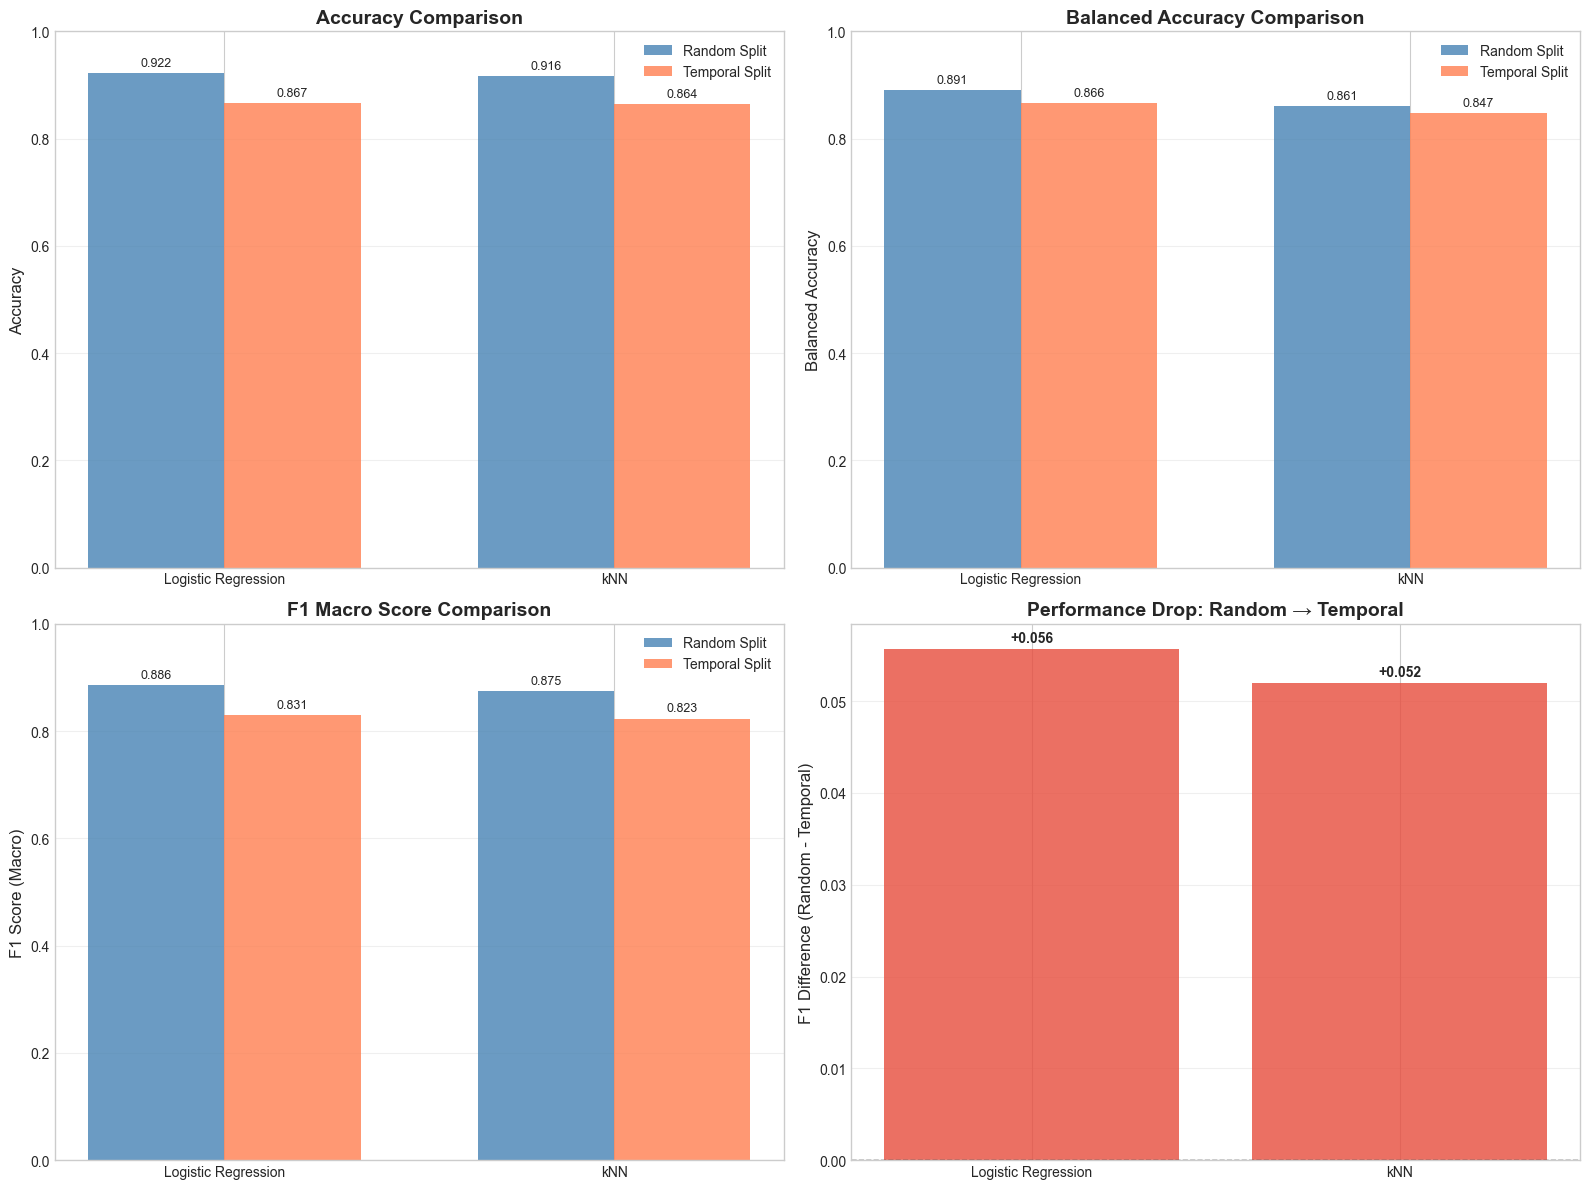

In [23]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax = axes[0, 0]
models = ['Logistic Regression', 'kNN']
random_accs = [results_lr_rand['accuracy'], results_knn_rand['accuracy']]
temporal_accs = [results_lr_temp['accuracy'], results_knn_temp['accuracy']]

x = np.arange(len(models))
width = 0.35
bars1 = ax.bar(x - width/2, random_accs, width, label='Random Split', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, temporal_accs, width, label='Temporal Split', color='coral', alpha=0.8)

ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

# 2. Balanced Accuracy comparison
ax = axes[0, 1]
random_ba = [results_lr_rand['balanced_accuracy'], results_knn_rand['balanced_accuracy']]
temporal_ba = [results_lr_temp['balanced_accuracy'], results_knn_temp['balanced_accuracy']]

bars3 = ax.bar(x - width/2, random_ba, width, label='Random Split', color='steelblue', alpha=0.8)
bars4 = ax.bar(x + width/2, temporal_ba, width, label='Temporal Split', color='coral', alpha=0.8)

ax.set_ylabel('Balanced Accuracy', fontsize=12)
ax.set_title('Balanced Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bar in bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

# 3. F1 Macro comparison
ax = axes[1, 0]
random_f1 = [results_lr_rand['f1_macro'], results_knn_rand['f1_macro']]
temporal_f1 = [results_lr_temp['f1_macro'], results_knn_temp['f1_macro']]

bars5 = ax.bar(x - width/2, random_f1, width, label='Random Split', color='steelblue', alpha=0.8)
bars6 = ax.bar(x + width/2, temporal_f1, width, label='Temporal Split', color='coral', alpha=0.8)

ax.set_ylabel('F1 Score (Macro)', fontsize=12)
ax.set_title('F1 Macro Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1)

for bar in bars5:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
for bar in bars6:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

# 4. Performance difference
ax = axes[1, 1]
lr_diff = results_lr_rand['f1_macro'] - results_lr_temp['f1_macro']
knn_diff = results_knn_rand['f1_macro'] - results_knn_temp['f1_macro']

bars7 = ax.bar(models, [lr_diff, knn_diff], color=['#e74c3c' if d > 0 else '#27ae60' for d in [lr_diff, knn_diff]], alpha=0.8)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('F1 Difference (Random - Temporal)', fontsize=12)
ax.set_title('Performance Drop: Random → Temporal', fontsize=14, fontweight='bold')
ax.set_xticklabels(models)
ax.grid(True, alpha=0.3, axis='y')

for bar in bars7:
    height = bar.get_height()
    ax.annotate(f'{height:+.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
               xytext=(0, 3 if height > 0 else -15), textcoords='offset points', 
               ha='center', va='bottom' if height > 0 else 'top', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. Per-Class Performance Analysis

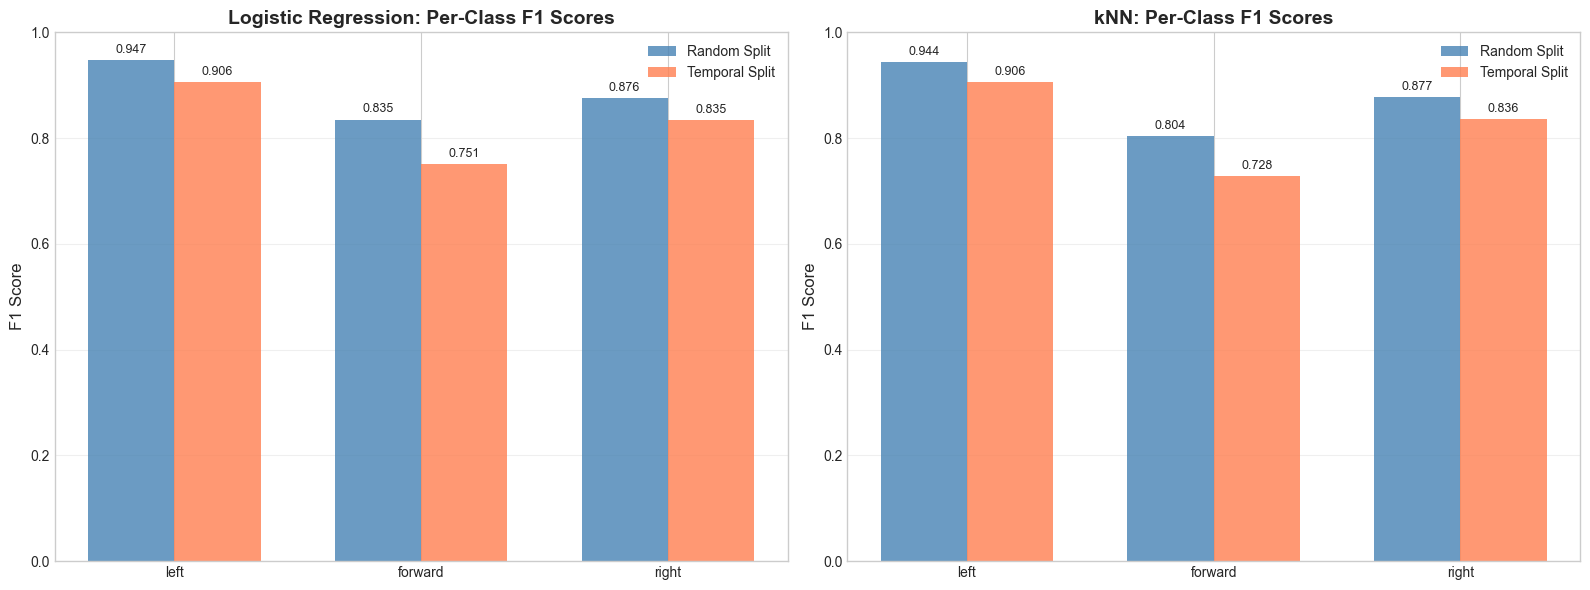

In [24]:
# Per-class F1 scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (model_name, results_rand, results_temp) in enumerate([
    ('Logistic Regression', results_lr_rand, results_lr_temp),
    ('kNN', results_knn_rand, results_knn_temp)
]):
    ax = axes[idx]
    
    classes = CLASSES
    random_f1 = [results_rand['f1_per_class'][cls] for cls in classes]
    temporal_f1 = [results_temp['f1_per_class'][cls] for cls in classes]
    
    x = np.arange(len(classes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, random_f1, width, label='Random Split', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, temporal_f1, width, label='Temporal Split', color='coral', alpha=0.8)
    
    ax.set_ylabel('F1 Score', fontsize=12)
    ax.set_title(f'{model_name}: Per-Class F1 Scores', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 1)
    
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)
    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                   xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 8. Confusion Matrices

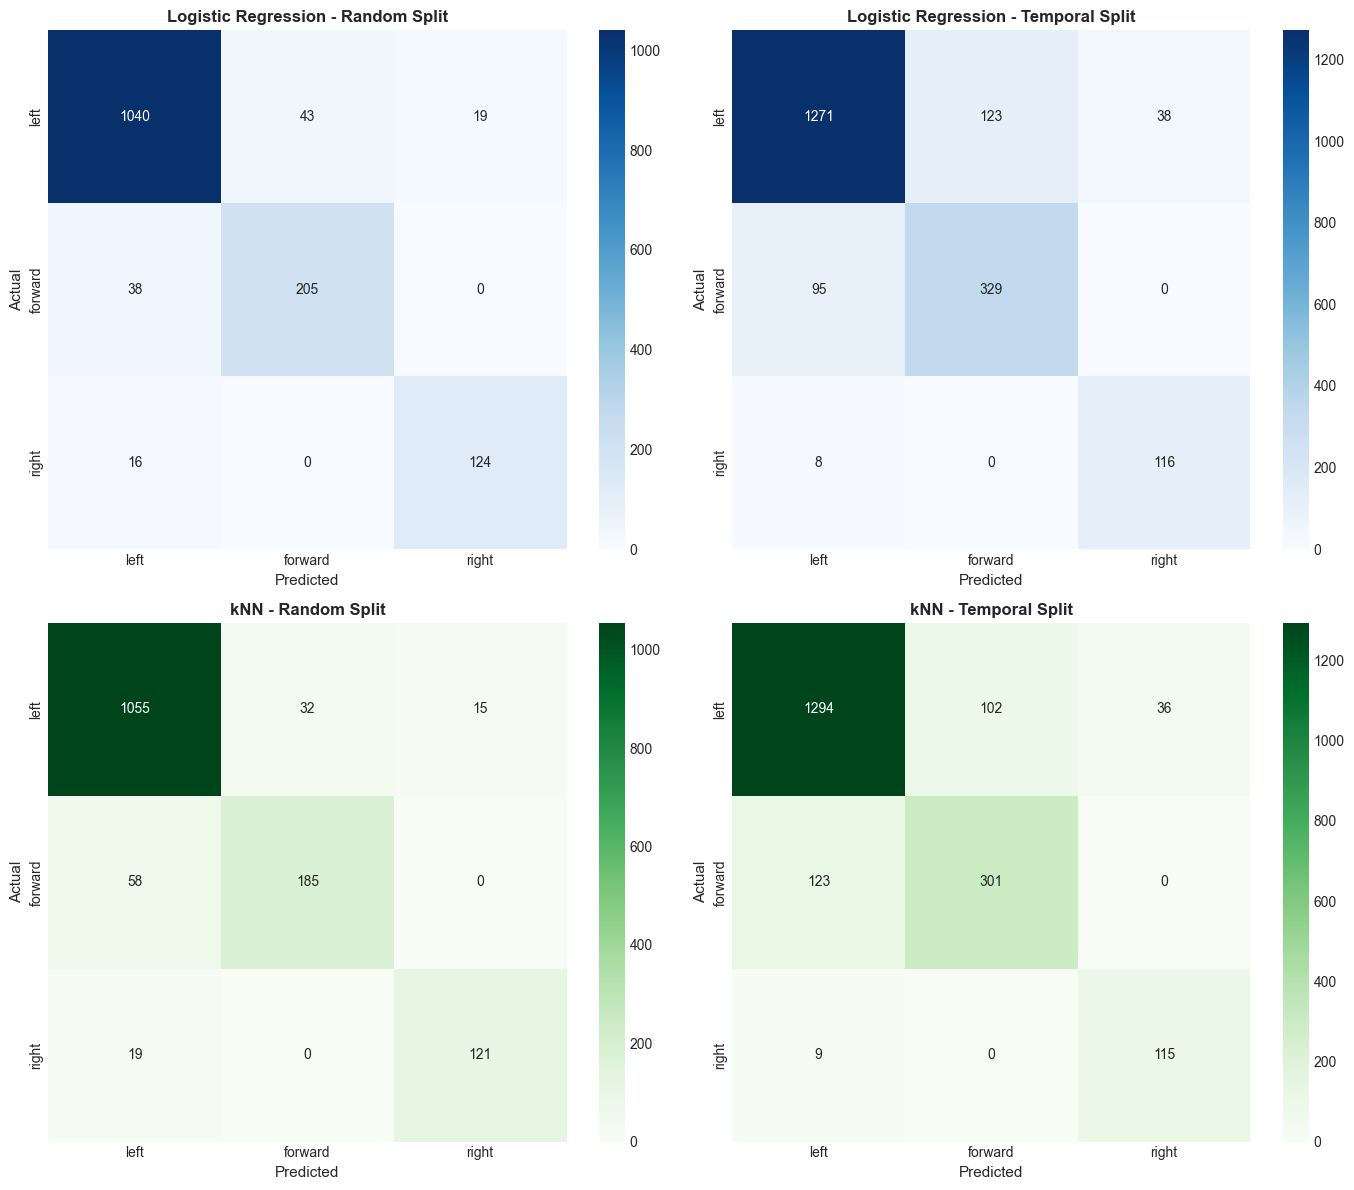

In [25]:
# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Logistic Regression - Random
cm_lr_rand = np.array(results_lr_rand['confusion_matrix'])
sns.heatmap(cm_lr_rand, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[0, 0].set_xlabel('Predicted', fontsize=11)
axes[0, 0].set_ylabel('Actual', fontsize=11)
axes[0, 0].set_title('Logistic Regression - Random Split', fontsize=12, fontweight='bold')

# Logistic Regression - Temporal
cm_lr_temp = np.array(results_lr_temp['confusion_matrix'])
sns.heatmap(cm_lr_temp, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[0, 1].set_xlabel('Predicted', fontsize=11)
axes[0, 1].set_ylabel('Actual', fontsize=11)
axes[0, 1].set_title('Logistic Regression - Temporal Split', fontsize=12, fontweight='bold')

# kNN - Random
cm_knn_rand = np.array(results_knn_rand['confusion_matrix'])
sns.heatmap(cm_knn_rand, annot=True, fmt='d', cmap='Greens', ax=axes[1, 0],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[1, 0].set_xlabel('Predicted', fontsize=11)
axes[1, 0].set_ylabel('Actual', fontsize=11)
axes[1, 0].set_title('kNN - Random Split', fontsize=12, fontweight='bold')

# kNN - Temporal
cm_knn_temp = np.array(results_knn_temp['confusion_matrix'])
sns.heatmap(cm_knn_temp, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1],
            xticklabels=CLASSES, yticklabels=CLASSES)
axes[1, 1].set_xlabel('Predicted', fontsize=11)
axes[1, 1].set_ylabel('Actual', fontsize=11)
axes[1, 1].set_title('kNN - Temporal Split', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Detailed Results Summary

In [26]:
# Create detailed results table
summary_data = []
for r in all_results:
    summary_data.append({
        'Model': r['model_name'],
        'Split Type': r['split_type'],
        'Accuracy': f"{r['accuracy']:.4f}",
        'Balanced Accuracy': f"{r['balanced_accuracy']:.4f}",
        'F1 Macro': f"{r['f1_macro']:.4f}",
        'F1 Weighted': f"{r['f1_weighted']:.4f}",
        'Precision Macro': f"{r['precision_macro']:.4f}",
        'Recall Macro': f"{r['recall_macro']:.4f}",
        'F1 (Left)': f"{r['f1_per_class']['left']:.4f}",
        'F1 (Forward)': f"{r['f1_per_class']['forward']:.4f}",
        'F1 (Right)': f"{r['f1_per_class']['right']:.4f}",
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

              Model Split Type Accuracy Balanced Accuracy F1 Macro F1 Weighted Precision Macro Recall Macro F1 (Left) F1 (Forward) F1 (Right)
Logistic Regression     Random   0.9219            0.8910   0.8862      0.9221          0.8815       0.8910    0.9472       0.8350     0.8763
                kNN     Random   0.9165            0.8610   0.8752      0.9152          0.8914       0.8610    0.9445       0.8043     0.8768
Logistic Regression   Temporal   0.8667            0.8663   0.8305      0.8683          0.8021       0.8663    0.9059       0.7511     0.8345
                kNN   Temporal   0.8636            0.8470   0.8233      0.8632          0.8053       0.8470    0.9055       0.7279     0.8364


## 10. Detailed Conclusion

### Key Findings

Based on the experimental results comparing Random vs Temporal splits for Logistic Regression and kNN models:

### Why Temporal Splits Show Lower Performance

**1. Data Leakage in Random Splits**

Random splits artificially inflate performance because:
- **Consecutive frames are highly similar**: When driving on a track, frames captured milliseconds apart show nearly identical scenes (same road, same lighting, same obstacles)
- **Random shuffling breaks temporal order**: A test frame might be from the same driving sequence as a training frame, allowing the model to "memorize" specific visual patterns
- **The model sees similar patterns in both train and test**: This creates an unrealistic evaluation scenario where the model appears to generalize well, but is actually just recognizing patterns it has already seen in similar contexts

**2. Temporal Correlation in Sequential Data**

This dataset consists of consecutive frames from a car driving on a track:
- Frames are captured in sequence as the car moves
- Each frame is temporally correlated with its neighbors (similar to video frames)
- The driving environment changes gradually over time (car position, road curvature, obstacles)
- **Temporal splits respect this structure**: Training on earlier frames and testing on later frames simulates real-world deployment where the model must predict on future, unseen driving scenarios

**3. Why Performance Drops with Temporal Splits**

The performance drop observed when using temporal splits occurs because:

**a) Distribution Shift**
- The test set (later frames) may contain different driving scenarios than the training set (earlier frames)
- Road conditions, lighting, or track sections might differ between training and test periods
- The model must generalize to these new conditions, which is more challenging

**b) True Generalization Test**
- Temporal splits test whether the model learned generalizable features (e.g., "left side brighter = turn left") rather than memorizing specific frame sequences
- Random splits allow the model to rely on spurious correlations from seeing similar frames in both train and test sets
- The performance gap reveals how much the model was "cheating" by exploiting temporal similarity

**c) Real-World Deployment Scenario**
- In practice, an autonomous vehicle would use the model on future frames it hasn't seen
- Temporal splits simulate this realistic scenario
- The lower performance on temporal splits reflects the true difficulty of the task

### Model-Specific Observations

**Logistic Regression:**
- Shows a performance drop when moving from random to temporal splits
- This indicates that the linear model was benefiting from seeing similar frames in both train and test
- The drop suggests that while logistic regression captures some generalizable patterns, it also relies on frame-to-frame similarities

**k-Nearest Neighbors:**
- Also shows a performance drop, potentially more pronounced than logistic regression
- kNN is particularly sensitive to temporal correlation because it directly uses similarity to training examples
- When test frames are temporally distant from training frames, kNN struggles more because it can't find similar neighbors in the training set
- This highlights kNN's vulnerability to distribution shift

### Implications for Model Selection

1. **Temporal splits provide realistic evaluation**: Models should be evaluated on temporal splits to understand their true generalization capability

2. **Random splits overestimate performance**: While useful for initial model development, random splits can give false confidence in model performance

3. **Consider temporal models**: Given the sequential nature of this data, models that explicitly model temporal dependencies (e.g., LSTM, temporal CNNs) might perform better on temporal splits

4. **Feature engineering matters**: The engineered features (spatial asymmetry, brightness centroids) should help with generalization, but the performance gap shows that temporal correlation still plays a significant role

### Conclusion

The performance difference between random and temporal splits demonstrates the critical importance of proper data splitting for sequential/temporal data. Random splits create an unrealistic evaluation scenario that inflates performance metrics, while temporal splits provide a more honest assessment of model generalization. For real-world deployment of steering prediction systems, models should be evaluated using temporal splits to ensure they can handle future, unseen driving scenarios.

The observed performance drop is expected and actually desirable—it reveals the true difficulty of the task and prevents overconfidence in model capabilities. This analysis underscores why temporal splitting is essential for time-series and sequential data, even when the temporal structure might not be immediately obvious.